<a href="https://colab.research.google.com/github/GFDRR/caribbean-rooftop-classification/blob/master/tutorials/02_building_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# MIT License
#
#@title Copyright (c) 2023 The World Bank/GFDRR { display-mode: "form" }
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Rooftop Classification from Drone Imagery for Disaster Risk Reduction and Reponse (Part II)
Author: [Isabelle Tingzon](https://issa-tingzon.github.io/), [The World Bank/GFDRR](https://gfdrr.org/)

# Overview
In the previous tutorial, [Building Footprint Delineation for Disaster Risk Reduction and Response (Part I)](https://colab.research.google.com/github/GFDRR/caribbean-rooftop-classification/blob/add%2Ftutorials/tutorials/01_building_delineation.ipynb), you learned how to generate building footprints using the Segment Anything Model for geospatial datasets. In this tutorial, you will learn how to use the building footprints you generated in Part I to classify rooftops into different roof type and roof material categories based on visual characteristics as observed from overhead images. See the examples of the RGB orthophoto and LiDAR image patches for each of the roof type and roof material categories.

<br>
<center><p><p> <img src="https://github.com/GFDRR/caribbean-rooftop-classification/blob/b28adde42111493b9026896726665abcfe11eeeb/assets/roof-type.png?raw=true" width="60%">
<br></center>

<center><p><p> <img src="https://github.com/GFDRR/caribbean-rooftop-classification/blob/b28adde42111493b9026896726665abcfe11eeeb/assets/roof-material.png?raw=true" width="60%">
<br>

<small>Examples of aerial images for the different roof type  (top) and roof material (bottom) categories</small></center>
<br>

Using AI-assisted roof type and roof material classification tools, we can quickly generated building classification maps from pre- and post-disaster aerial images to rapidly identify damaged buildings after an extreme hazard event as illustrated below.

<br>
<center><p><p> <img src="https://github.com/GFDRR/caribbean-rooftop-classification/blob/b28adde42111493b9026896726665abcfe11eeeb/assets/results.png?raw=true" width="65%">
<br>
<small>An example of pre- and post-disaster roof material classification map for Colihaut, Dominica</small></center>
<br>


# Application Context
Under the **Digital Earth Project for Resilient Housing and Infrastructure in the Caribbean** at [GFDRR](https://gfdrr.org/) , we aim to support capacity-building in the Caribbean by training local communities to leverage Earth observation (EO)-based solutions in support of resilient infrastructure and housing operations. This includes developing local skills and capabilities to produce and update critical building information needed for governments to bolster resilience in the region. Specifically, the program supports the training of local communities to operate UAVs or drones in order to enable more frequent and inexpensive collection of very high-resolution aerial images. From the drone images, AI models can then be used to extract meaningful information such as building footprints, roof material, and building damage levels.

This two-part tutorial provides a brief walkthrough of how to leverage existing AI tools for the automatic extraction of rooftop attributes from drone images. This tutorial is intended for GIS practitioners, community mappers, disaster responders, and other non-technical stakeholders interested in the rapid extraction of meaningful information from VHR aerial images for disaster reduction and response.

# Install Dependencies

In [1]:
%%capture
!pip -q install leafmap rasterio json_fix leafmap mapclassify segment-geospatial ipysheet
!pip -q install -U git+https://github.com/IDEA-Research/GroundingDINO.git
!pip -q install --upgrade --no-cache-dir gdown
!pip install safetensors
!pip install --upgrade huggingface_hub
!pip install -U transformers[torch]

In [2]:
!git clone https://github.com/GFDRR/caribbean-rooftop-classification.git
%cd caribbean-rooftop-classification/
!git checkout add-huggingface-integration

Cloning into 'caribbean-rooftop-classification'...
remote: Enumerating objects: 1478, done.
remote: Counting objects: 100% (231/231), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 1478 (delta 121), reused 197 (delta 117), pack-reused 1247 (from 1)
Receiving objects: 100% (1478/1478), 145.30 MiB | 15.63 MiB/s, done.
Resolving deltas: 100% (898/898), done.
/content/caribbean-rooftop-classification
error: pathspec 'add-huggingface-integration' did not match any file(s) known to git


In [3]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip install -q localtileserver

After running the cells above, you may need to restart your runtime. To do this go to Runtime >> Restart and run all.

## Imports and Setup

In [4]:
import os
import sys
import gdown
import joblib
import subprocess

import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import pandas as pd
import numpy as np
import geopandas as gpd
from tqdm.notebook import tqdm

from shapely.geometry import box
import leafmap

sys.path.insert(0, "./utils/")
import pred_utils
import config
from cnn_utils import GFDRRModel

%load_ext autoreload
%autoreload 2

# Download Drone Image

To download your aerial image to Google Colab, you can either:

1. Directly specify the URL of your TIFF image (`direct_download`).  Feel free to browse [OpenAerialMap](https://map.openaerialmap.org/) for examples of free and openly available aerial images (e.g drone images, satellite images).
2. Upload your aerial image to Google Drive and extract the Document ID from your file (`google_drive`). The Document ID can be found by right clicking on the file >> choose "Share" >> change access permissions to "Anyone with the link can view" >> choose "Copy link". The Document ID can be extract from the link as follows:

```
https://drive.google.com/file/d/<document_id>/view?usp=sharing
```

For example, if the link to your image file is `https://drive.google.com/file/d/1afodaBDzBZbCGMYyTLMcX3oYOjLLpPeI/view?usp=sharing`, the Document ID is `1afodaBDzBZbCGMYyTLMcX3oYOjLLpPeI`.

In [23]:
# Create output directory
data_dir = "./data/"
config_dir = "./configs/cnn/"

image_file = os.path.join(data_dir, "drone.tif")
#@markdown Select mode of download for the TIFF image:
mode = 'direct_download'  #@param ["direct_download", "google_drive"]
#@markdown If you chose `direct_download`, specify the URL of the aerial image. Make sure that the file is publicly accessible.
url = "https://oin-hotosm.s3.amazonaws.com/5a95e6312553e6000ce5ad22/0/d3b89c33-ffca-4a2b-8629-ab4e849d968d.tif" #@param {type:"string"}
#@markdown If you chose `google_drive`, specify the Document ID of the file uploaded in Google Drive.
document_id = '1VylcfGaCwcYr5OLYWY_KAGz3sEpiIOZc'  #@param {type:"string"}

# Create output directory
out_dir = './output/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# The final building delineation output file
filename = "output.gpkg"
out_file = os.path.join(out_dir, filename)

# Create directory for the drone image
image_dir = "./data/rasters/drone/"
if not os.path.exists(image_dir):
    os.makedirs(image_dir)

if mode == "google_drive":
  url = f"https://drive.google.com/uc?id={document_id}"
  gdown.download(url, image_file, quiet=False)
if mode == "direct_download":
  !wget {url} -O {image_file}


--2024-09-12 12:58:03--  https://oin-hotosm.s3.amazonaws.com/5a95e6312553e6000ce5ad22/0/d3b89c33-ffca-4a2b-8629-ab4e849d968d.tif
Resolving oin-hotosm.s3.amazonaws.com (oin-hotosm.s3.amazonaws.com)... 54.231.171.33, 52.217.227.73, 52.217.134.25, ...
Connecting to oin-hotosm.s3.amazonaws.com (oin-hotosm.s3.amazonaws.com)|54.231.171.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18031676 (17M) [image/tiff]
Saving to: ‘./data/drone.tif’

./data/drone.tif    100%[===================>]  17.20M  7.88MB/s    in 2.2s    

2024-09-12 12:58:06 (7.88 MB/s) - ‘./data/drone.tif’ saved [18031676/18031676]



# Download Building Footprints

In [24]:
bldgs_file = os.path.join(data_dir, "building_footprints.gpkg")
#@markdown Specify the Document ID of the building footprint file uploaded in Google Drive.
document_id = '1T2ImSu76XgbGeYKJ4CMNxKJFvEWfs9HV'  #@param {type:"string"}

url = f"https://drive.google.com/uc?id={document_id}"
gdown.download(url, bldgs_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1T2ImSu76XgbGeYKJ4CMNxKJFvEWfs9HV
To: /content/caribbean-rooftop-classification/data/building_footprints.gpkg
100%|██████████| 131k/131k [00:00<00:00, 33.7MB/s]


'./data/building_footprints.gpkg'

# Load Datasets

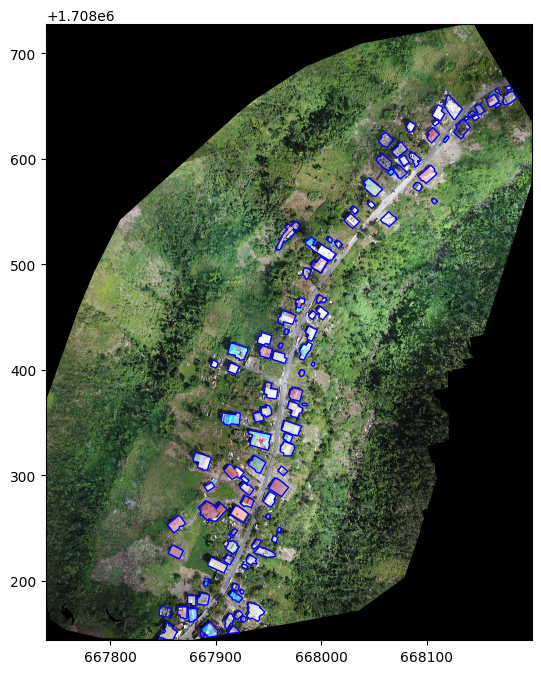

In [25]:
# Load building footprints
bldgs = gpd.read_file(bldgs_file).reset_index(drop=True)[['geometry']]
bldgs['UID'] = bldgs.index

# Load image
image = rio.open(image_file)
fig, ax = plt.subplots(figsize=(8,8))
bldgs = bldgs.to_crs(image.crs)
bldgs.plot(facecolor="none", edgecolor='blue', ax=ax, aspect=1)

# Visualize datasets
show(image, ax=ax);

# Model Prediction

In [26]:
# Create model directory
model_dir = './models/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

filename = "cnn-roof_material-resnet50-RGB_DOM"
cnn_config_file = os.path.join(config_dir, f"{filename}.yaml")
model_file = os.path.join(model_dir, f"{filename}.pth")

# Download model file
gid = "1mB_EfM9UQCwi1TLKeFU4ALmvCYNg9s7U"
url = f"https://drive.google.com/uc?id={gid}"
gdown.download(url, model_file, quiet=False)

bldgs = pred_utils.predict_image(
    bldgs, image_file, cnn_config_file, model_file=model_file
)

filename = "cnn-roof_type-efficientnetb0-RGB_DOM_LCA"
cnn_config_file = os.path.join(config_dir, f"{filename}.yaml")
model_file = os.path.join(model_dir, f"{filename}.pth")

# Download model file
gid = "1bNzfcknuQ_2hfwF6dNQ28jgLLHFADiH2"
url = f"https://drive.google.com/uc?id={gid}"
gdown.download(url, model_file, quiet=False)

preds = pred_utils.predict_image(
    bldgs, image_file, cnn_config_file, model_file=model_file
)

#@markdown Specify your output filename
filename = "output.gpkg" #@param {type:"string"}
out_file = os.path.join(out_dir, filename)
preds.to_file(out_file)

from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()
drive_service = build('drive', 'v3')
file_metadata = {'name': out_file.split("/")[-1]}
media = MediaFileUpload(
    out_file,
    resumable=True
)
created = drive_service.files().create(
    body=file_metadata,
    media_body=media,
    fields='id'
).execute()
print('Upload to Google Drive done.')
print(f'Please download {file_metadata["name"]} manually from Google Drive.')
print(f'Search link: https://drive.google.com/drive/search?q={file_metadata["name"]}')

preds.head(3)

Downloading...
From (original): https://drive.google.com/uc?id=1mB_EfM9UQCwi1TLKeFU4ALmvCYNg9s7U
From (redirected): https://drive.google.com/uc?id=1mB_EfM9UQCwi1TLKeFU4ALmvCYNg9s7U&confirm=t&uuid=e81004d7-32bc-479a-a300-9c33431bf52e
To: /content/caribbean-rooftop-classification/models/cnn-roof_material-resnet50-RGB_DOM.pth
100%|██████████| 94.4M/94.4M [00:01<00:00, 80.8MB/s]
100%|███████████████| 107/107 [00:30<00:00,  3.56it/s]
Downloading...
From: https://drive.google.com/uc?id=1bNzfcknuQ_2hfwF6dNQ28jgLLHFADiH2
To: /content/caribbean-rooftop-classification/models/cnn-roof_type-efficientnetb0-RGB_DOM_LCA.pth
100%|██████████| 16.4M/16.4M [00:00<00:00, 60.1MB/s]
100%|███████████████| 107/107 [00:13<00:00,  7.67it/s]


Upload to Google Drive done.
Please download output.gpkg manually from Google Drive.
Search link: https://drive.google.com/drive/search?q=output.gpkg


geometry  UID  ROOF_MATERIAL  \
0  POLYGON ((667861.798 1708153.330, 667864.199 1...    0  HEALTHY_METAL   
1  POLYGON ((667889.054 1708146.529, 667888.054 1...    1      BLUE_TARP   
2  POLYGON ((667879.502 1708173.985, 667882.203 1...    2      BLUE_TARP   

   ROOF_MATERIAL_PROB  INCOMPLETE_PROB  HEALTHY_METAL_PROB  \
0            0.935431         0.030600            0.935431   
1            0.897506         0.036516            0.022195   
2            0.812908         0.024134            0.060905   

   IRREGULAR_METAL_PROB  CONCRETE_CEMENT_PROB  BLUE_TARP_PROB ROOF_TYPE  \
0              0.018151              0.009321        0.006498       HIP   
1              0.023493              0.020290        0.897506       HIP   
2              0.077783              0.024271        0.812908     GABLE   

   ROOF_TYPE_PROB  NO_ROOF_PROB  GABLE_PROB  HIP_PROB  FLAT_PROB  
0        0.911510      0.022157    0.034080  0.911510   0.032254  
1        0.660496      0.021644    0.050561  0.660496   0.267299  
2        0.958653      0.013604    0.958653  0.009978   0.017765

# Visualize Predictions

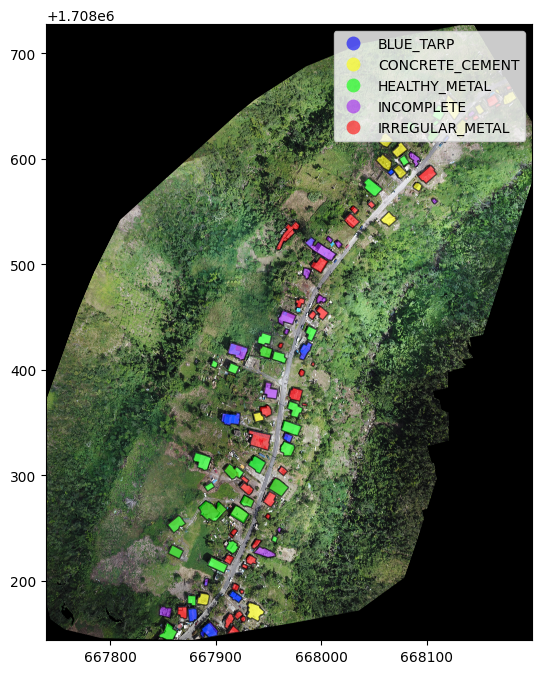

In [27]:
#@markdown Select roof attribute to visualize:
attribute = 'ROOF_MATERIAL'  #@param ["ROOF_MATERIAL", "ROOF_TYPE"]

image = rio.open(image_file)
fig, ax = plt.subplots(figsize=(8,8))

color_dict = {
    'ROOF_MATERIAL':{
      "BLUE_TARP": '#0000FF',
      "CONCRETE_CEMENT": '#FFFF00',
      "HEALTHY_METAL": '#00FF00',
      'IRREGULAR_METAL': '#A020F0',
      'INCOMPLETE': '#FF0000'
    },
    'ROOF_TYPE':{
      "FLAT": '#FFFF00',
      "HIP": '#00FF00',
      'GABLE': '#A020F0',
      'NO_ROOF': '#FF0000'
    }
}
preds['color'] = preds[attribute].map(color_dict[attribute])
cmap = colors.ListedColormap(list(color_dict[attribute].values()))
preds.plot(
    column=attribute,
    cmap=cmap,
    edgecolor='black',
    alpha=0.6,
    ax=ax,
    aspect=1,
    legend=True,
)
show(image, ax=ax);

# Interactive Plot

In [28]:
data = gpd.GeoDataFrame({"id":1,"geometry":[box(*image.bounds)]}, crs=image.crs).to_crs("EPSG:4326")
centroid = data.geometry.values[0].centroid

map = leafmap.Map(center=[centroid.y, centroid.x], layers_control=True, zoom=20)
map.add_raster(image_file, layer_name="Image", zoom=20)

def fill_color(feature):
  return {
    "color": feature['properties']['color'],
    "fillColor": feature['properties']['color'],
  }
style = {'fillOpacity': 0.5}
map.add_legend(
    title='Legend',
    legend_dict=color_dict[attribute],
    draggable=True
)
map.add_gdf(
    preds,
    layer_name=attribute,
    info_mode="on_hover",
    style=style,
    style_callback=fill_color
)
map

Map(center=[15.4475165, -61.434464500000004], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom…